### Anomaly Detection with Gaussian Mixture Model (GMM)

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from scratch_libraries.metrics import ClassificationMetrics

In [13]:
df = pd.read_csv('./datasets/cardio.csv')

display(df)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,y
0,0.004912,0.693190,-0.20364,0.59532,0.35319,-0.061401,-0.27829,-1.65040,0.759070,-0.42049,...,-0.798380,1.85470,0.622630,0.96308,0.301460,0.193110,0.231500,-0.289790,-0.49329,0
1,0.110730,-0.079903,-0.20364,1.26890,0.39625,-0.061401,-0.27829,-1.71030,0.759070,-0.42049,...,-0.798380,1.85470,0.278620,0.96308,0.301460,0.129270,0.093563,-0.256390,-0.49329,0
2,0.216550,-0.272440,-0.20364,1.05100,0.14875,-0.061401,-0.27829,-1.71030,1.106500,-0.42049,...,-1.332900,0.31469,2.342700,-0.48828,0.061002,0.065417,0.024596,-0.256390,1.14000,0
3,0.004912,0.727350,-0.20364,1.21220,-0.68360,-0.061401,-0.27829,-1.71030,1.106500,-0.42049,...,-1.332900,0.31469,1.654700,-0.48828,0.061002,0.193110,0.093563,-0.323190,1.14000,0
4,-0.100900,0.363590,1.32140,1.02710,0.14136,-0.061401,-0.27829,-0.99236,-0.051613,-0.42049,...,-0.085638,-0.56533,0.278620,-0.48828,-0.059229,0.065417,0.024596,-0.456790,1.14000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1826,-0.418360,-0.919990,-0.16118,0.82956,0.95302,-0.061401,3.06080,1.22120,1.338100,-0.42049,...,-0.976560,1.52470,0.622630,-0.48828,-1.982900,-2.616200,-1.561700,0.244620,-0.49329,1
1827,-0.418360,-0.919990,-0.17106,0.79663,0.82351,-0.061401,3.56530,1.28100,1.453900,-0.42049,...,-0.976560,1.52470,-0.065382,-0.48828,-1.862700,-2.807700,-1.699600,0.010817,-0.49329,1
1828,-0.418360,-0.919990,-0.16463,0.95240,1.12050,-0.061401,2.78900,1.22120,1.222300,-0.42049,...,-0.976560,1.52470,0.622630,-0.48828,-1.922800,-2.488500,-1.492700,0.244620,-0.49329,1
1829,-0.418360,-0.919990,-0.15093,0.69573,1.21240,-0.061401,2.48480,1.22120,1.222300,-0.42049,...,-0.976560,1.52470,0.278620,-0.48828,-1.321700,-2.297000,-1.423700,0.144420,-0.49329,1


### Anomaly Detection

- **Training on Normal Data (zeros):** The model is trained exclusively on data labeled as `0`, representing the "normal" or majority class. In our dataset, this corresponds to patients **without diabetes**. The goal during training is to accurately learn the characteristics of normal data, specifically its underlying distribution.

- **Testing with Both Classes:** The test set includes data labeled as both `0` and `1`. Here, data labeled as `1` represents the **anomalous** or minority class. In this context, `1` corresponds to patients **with diabetes**. By evaluating the model on both classes, we can assess its ability to differentiate between normal and anomalous data.

- **Goal:** The objective is to model the distribution of the normal class (`0`) with high accuracy during training. This allows the model to identify deviations from this learned distribution in the test phase, flagging such deviations (labeled as `1`) as anomalies.

To do that we will use a **Gaussian Mixture Model (GMM)** since:

- **Probabilistic Nature**: GMM provides probabilities for each data point belonging to various Gaussian components of the data distribution. This makes it possible to classify points based on how likely they are to belong to the normal class.

- **Nuanced Anomaly Detection**: Once trained out GMM, we can then calculate the probability of each new data point ($ x_{\text{test}}^{(i)} $) to appartain to the mixture as the likelihood of the same test data point to belong to each of the $k$ Gaussian components of the learned mixture:
    $$ p(x_{\text{test}}^{(i)}|\theta) = \sum_{j=1}^K \pi_j \, p_j(x_{\text{test}}^{(i)}|\theta_j) $$

    Test data points with low probability densities are likely to lie outside the learned normal data distribution, indicating potential anomalies.
    Hower just like that we have probabilities for them, but at the end we aim to classify new samples as anomalies or not. To do that we set a threshold $ϵ$ that it will be used as anomaly flag. Thus, if the probability value is below the fixed threshold $ϵ$, then the new data point is classified as an anomaly, otherwise it is classified as normal.
    $$ p(x_{\text{test}}^{(i)}|\theta) < \epsilon \implies \text{flag anomaly} $$
    $$ p(x_{\text{test}}^{(i)}|\theta) \geq \epsilon \implies \text{OK} $$
    For instance, if $p(x_{\text{test}}^{(i)}|\theta) < 0.1$ (so it has a low probaility to appartain to the mixture of gaussians representing our distribution), the data point is classified as anomalous.

- **Flexibility**: GMM effectively captures the complexity of the normal data's distribution by combining multiple Gaussian components, enabling more accurate anomaly detection.

By leveraging GMM, we aim to effectively distinguish between normal data (patients without diabetes) and anomalies (patients with diabetes) based on the learned probability distribution.


In [14]:
zeros = df[df.y == 0]
ones = df[df.y == 1]

zeros_train, zeros_test = train_test_split(zeros, test_size=0.1, random_state=42)

In [15]:
training = zeros_train.drop(columns='y').values # just of zeros (normal class)
# Prepare the testing data
# - Combine the 'zeros_test' (10% of zeros) with all rows in 'ones' (where y == 1).
# - Drop the target column 'y' to keep only the feature values
test = pd.concat([zeros_test, ones]).drop(columns='y').values
# Prepare the testing labels
# - Create an array of 0's for all rows in 'zeros_test' (corresponding to the zeros subset)
# - Create an array of 1's for all rows in 'ones' (corresponding to the ones subset)
# - Concatenate the arrays to form a single label array for the test data
test_labels = np.hstack([np.zeros(zeros_test.shape[0]), np.ones(ones.shape[0])])

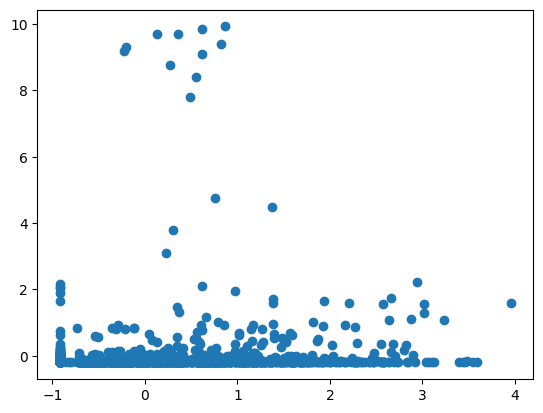

In [16]:
# This is just a plot of two dimensions of our training data (features at indices 1 and 2). However note that our dataset consists of 21 features,
# so we have a 21-dimensional feature space.
plt.scatter(training[:, 1], training[:, 2])
plt.show()

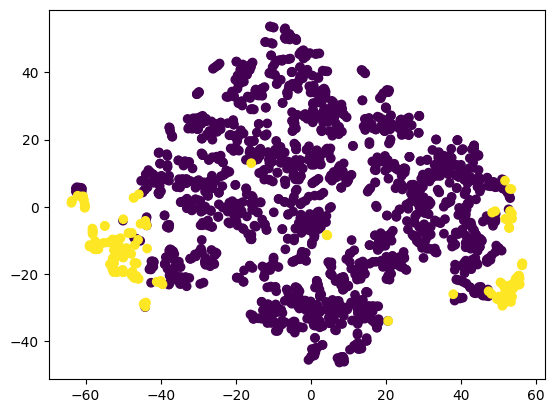

In [17]:
"""
Here we report just a visualization to build the idea of what we aim to do (you don't have to understand the code). Essentially, we aim to
learn the distribution of our data so that once the model has effectively captured this distribution, it becomes straightforward to identify
points that deviate significantly from it, classifying them as anomalies. More specifically with GMM we have the possibility to do that with
probabilites, so we can say that point that have low probability (e.g the ones in the two sides in this visualization) are anomalies.
At the end (during prediction) we can easily classify them based on the learned probabilistic structure, using a given treshold. 
E.g doing that we would obtain something like shown in the plot where:
 - Purple points represent the data that the model classify as belonging to the learned distribution.
 - Yellow points represent the data that the model classify as anaomalies.
"""

# Note: Here just to show graphically this in 2 dimensions, we compressed our 21 fetures in 2 compressed fetures (we performed dimensionality reduction basically
# with a technique called t-SNE that we will not cover during the course)
data_complete = df.drop(columns='y').values
labels_complete = df['y'].values

tsne = TSNE(n_components=2, random_state=42)
data_viz = tsne.fit_transform(data_complete)

plt.scatter(data_viz[:, 0], data_viz[:, 1], c=labels_complete)
plt.show()

In [18]:
# Use GMM to cluster data, identifying patterns based on Gaussian components. In particular we use 5 Gaussians components.
gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=42)
gmm.fit(training) # Estimate model parameters with the EM algorithm.

GaussianMixture(n_components=5, random_state=42)

The **parameters** learned by the model via the **Expectation Maximization (EM)** algorithm are:
- **gmm.weights_** ($π_j$, so the **mixing coefficients**): proportions (probability) of each j-th Gaussian component among all Gaussians in the mixture. These values indicate how much each Gaussian component contributes to the overall data distribution. For instance, the first component has a weight of 0.2977, meaning roughly 29.77% of the data belongs to the first Gaussian component.
**Note**: They sum up to 1 ($\sum_{j=1}^K \pi_j = 1$).


- **gmm.means_** ($μ_j$): The **mean** of each Gaussian component in the mixture. This is an array of vectors, where each vector corresponds to the mean of a given Gaussian component. Specifically the values in each vector represent the coordinates of the mean of that component across the features. E.g. in this case we will have 21 values in each vector since our dataset is made of 21 features.

- **gmm.covariances_** ($Σ_j$): The **covariance** of each Gaussian component in the mixture. This is an array of metrices, where each matrix corresponds to the covaraince of one Gaussian component. In particular they are square matrices that defines the covariance structure of the Gaussian component (e.g., how the features are correlated within that component).

In [19]:
print('Weights: ', gmm.weights_)
print('Means: ', gmm.means_)
print('Covariances: ', gmm.covariances_)

Weights:  [0.21983948 0.44374866 0.07643608 0.24184708 0.0181287 ]
Means:  [[-0.01559137  0.43591216 -0.037272    0.15579754  0.5131562  -0.061401
  -0.27829     0.31947037  0.43793402 -0.40227129 -0.26154167  0.60630167
  -0.51467483  0.46517242  0.4839007   0.10887503  0.24562822  0.09214947
   0.206753    0.42653338  0.20612798]
 [ 0.15719245 -0.06349396 -0.17258061 -0.17706201 -0.6836     -0.061401
  -0.27829     0.05138814 -0.57224183  0.14575161  0.17743246 -0.63475622
   0.64168442 -0.32826439 -0.47110159 -0.30854425  0.18378916  0.35638598
   0.23524233 -0.56941358 -0.14044115]
 [-0.40827648  0.49125153  1.37247759  0.00369219  0.5523949  -0.061401
   0.49941134 -0.66643903  1.39918706 -0.41939628  0.14631432  1.29939069
  -1.02749156  1.11350163  1.00809833  0.0348612  -0.05572713 -0.41203176
  -0.13532016  0.92469754 -0.01191947]
 [-0.0820923   0.00435266 -0.20364     0.2851782   0.29273532 -0.061401
  -0.27829    -0.74523176  0.09855409 -0.14136215  0.18466759  0.14338789
  

#### Predictions from the Gaussian Mixture Model

The probality of a test data point $ x_{\text{test}}^{(i)} $ to belong to the mixture is given by the sum of the probabilities that the same test data point belongs to each of the $ K $ Gaussian components in the mixture. This is represented as:
$$
p(x_{\text{test}}^{(i)}|\theta) = \sum_{j=1}^K \pi_j \, p_j(x_{\text{test}}^{(i)}|\theta_j) = \sum_{j=1}^K \pi_j \, \mathcal{N}\big(x_{\text{test}}^{(i)} \mid \mu_j, \Sigma_j\big)
$$

where:
- $ \pi_j $ is the weight of the $ j $-th Gaussian component,
- $ p_j(x_{\text{test}}^{(i)}|\theta_j) $ is the probability density of the data point $ x $ under the $ j $-th Gaussian component.


We can extend this to all test data points representing it in vector notation as:

$$ p(x_{\text{test}}|\theta) = \mathbf{w} \cdot \mathbf{p}(x_{\text{test}})^T $$

where:
- $ \mathbf{w} $ is the vector of weights of the Gaussian components (of shape $ 1 \times K $),
- $ \mathbf{p}(x_{\text{test}}) $ is the matrix of probabilities that each data point belongs to each Gaussian component (shape $ m \times K $).


In Python, this is equivalent to the following operation:
```python
gmm.weights_.dot(gmm.predict_proba(test).T)
```

#### Anomaly Detection

Once we have $ p(x_{\text{test}}^{(i)}|\theta) $, we can fix a threshold $ \epsilon $ to classify data points as normal or anomalous. For example, if $ p(x_{\text{test}}|\theta) < 0.1 $, the data point can be classified as an **anomaly**.



In [30]:
clf_metrics = ClassificationMetrics(gmm)
preds = gmm.weights_.dot(gmm.predict_proba(test).T) < 0.1 # threshold

print(clf_metrics.compute_performance(preds, test_labels))

{'confusion_matrix': array([[155,  11],
       [ 74, 102]]), 'accuracy': 0.7514619883040936, 'error_rate': 0.2485380116959064, 'precision': 0.9026548672566371, 'recall': 0.5795454545454546, 'fn_rate': 0.4204545454545454, 'specificity': 0.9337349397590361, 'fp_rate': 0.0662650602409639, 'f1_score': 0.7058823529411764}
